In [49]:
# Necessary modules have been imported for you
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [20]:
train = train.dropna()

In [21]:
train.head()


textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [22]:
train.describe()


textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

In [23]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='sentiment', ylabel='count'>

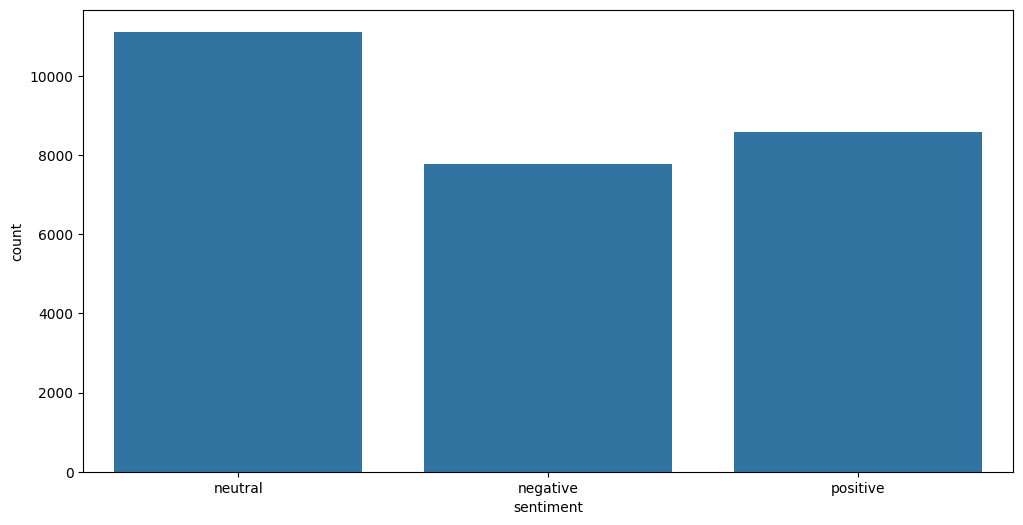

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [25]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [26]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [27]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [28]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [29]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [30]:
train.head()

textID                                               text  \
0  0fab80d6b2                    \tREALLY?? oh.. sorry yall  lol   
1  8106d4c6fa                          _beckett Thanks so much !   
2  3792c7b13e        You`ll be missed!!  Bring me back  a key...   
3  b58a92fe10                 get lit  I am  http://bit.ly/OASQR   
4  18180bb2ec       Good morning to you !  Its so pretty outs...   

                   selected_text sentiment  jaccard_score  Num_words_ST  \
0                          sorry  negative       0.200000             1   
1                 beckett Thanks  positive       0.166667             2   
2                 You`ll be miss  negative       0.222222             3   
3  get lit  I am  http://bit.ly/   neutral       0.666667             5   
4                      Its so pr  positive       0.181818             3   

   Num_word_text  difference_in_words  
0              5                    4  
1              5                    3  
2              8                    5  
3              5                    0  
4             10                    7

In [31]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

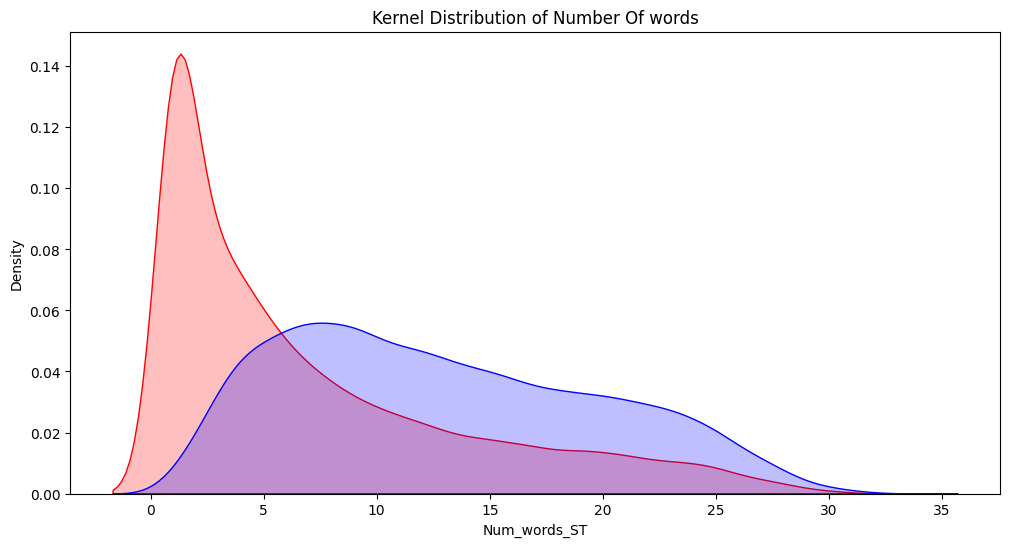

In [32]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

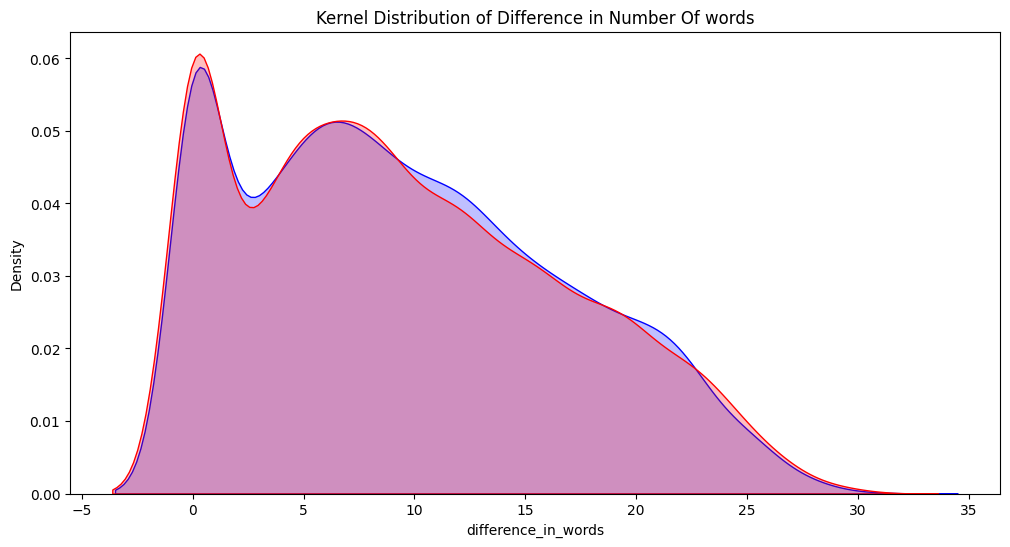

In [33]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

<Axes: xlabel='difference_in_words'>

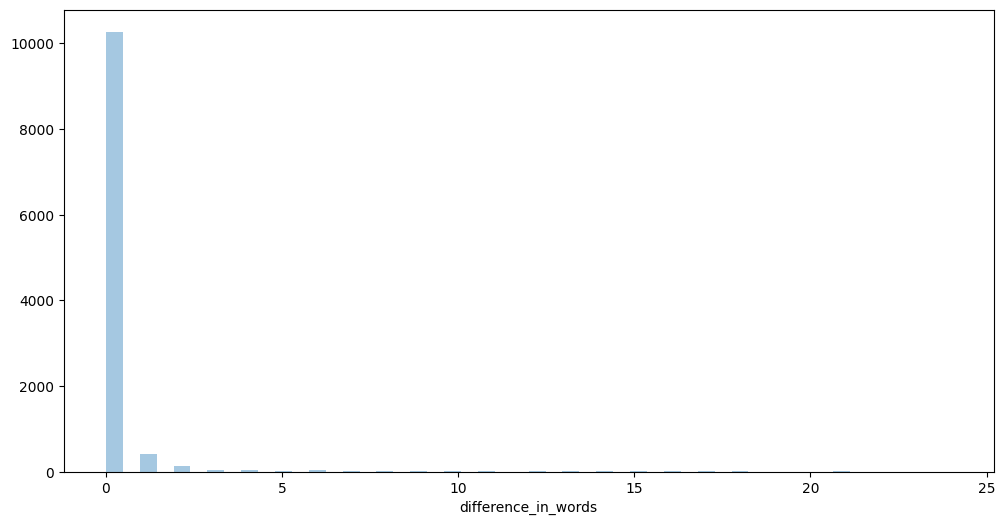

In [34]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

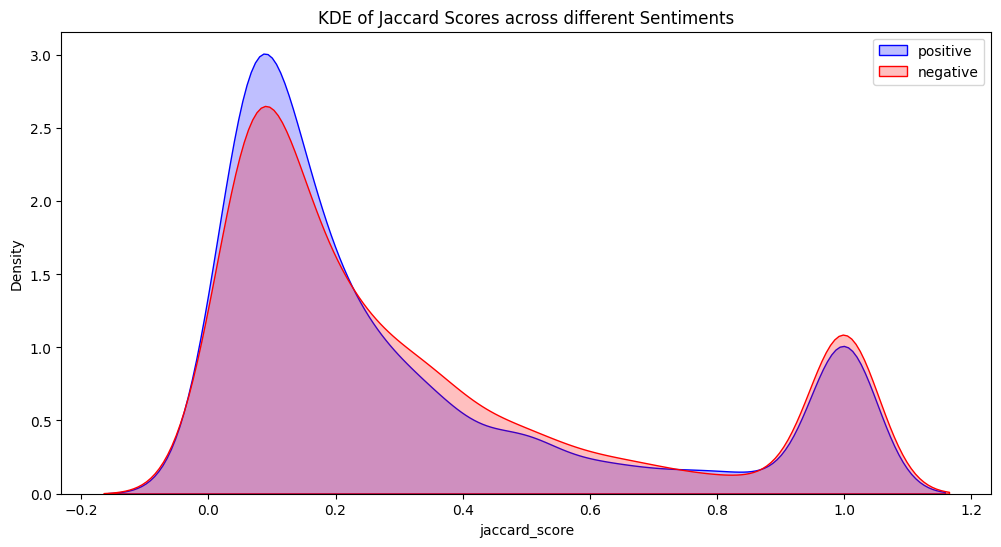

In [35]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

<Axes: xlabel='jaccard_score'>

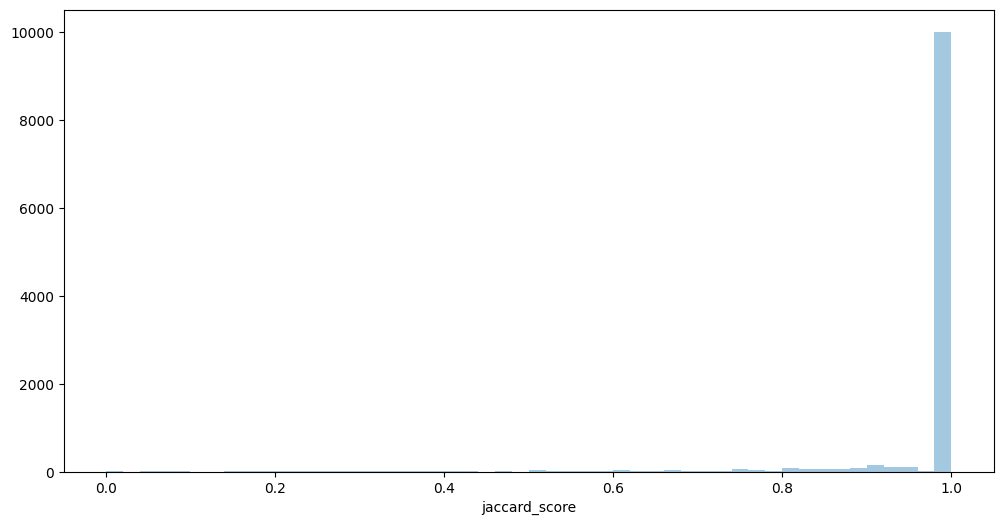

In [36]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

In [37]:
k = train[train['Num_word_text']<=2]

In [41]:
k.groupby('sentiment').mean(numeric_only=True)['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [42]:
k[k['sentiment']=='positive']

textID               text      selected_text sentiment  \
100    3ff9947935        **** right!        **** right!  positive   
151    d2f915b8c7      Good Morning!               Good  positive   
154    b4fa2d20e4           Good one           Good one  positive   
155    5714d8c2c3         Goodnight.          Goodnight  positive   
334    6d9bd35d32          Thank you              Thank  positive   
...           ...                ...                ...       ...   
26454  0ccac3f8b7  sweet situations.  sweet situations.  positive   
26484  6475ddf649            thanks              thanks  positive   
26499  274181e2e2             thanx               thanx  positive   
26933  28fc81d56a       wants cookie       wants cookie  positive   
27319  352e2cdec2        work   Yay!                Yay  positive   

       jaccard_score  Num_words_ST  Num_word_text  difference_in_words  
100              1.0             2              2                    0  
151              0.5             1              2                    1  
154              1.0             2              2                    0  
155              0.0             1              1                    0  
334              0.5             1              2                    1  
...              ...           ...            ...                  ...  
26454            1.0             2              2                    0  
26484            1.0             1              1                    0  
26499            1.0             1              1                    0  
26933            1.0             2              2                    0  
27319            0.0             1              2                    1  

[207 rows x 8 columns]

In [43]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [44]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [45]:
train.head()

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words  
0                    4  
1                    3  
2                    5  
3                    0  
4                    7

In [46]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [47]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [52]:
import nltk
nltk.download('stopwords')
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [53]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [54]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [57]:
# TODO 3: remove stopword from temp_list1 using lambda function
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())
# Write your code here
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x))

In [60]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(26))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [61]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [74]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [69]:
# TODO 5: write code for most common words from text with positive sentiment and make a cmap in green by storing in 'temp_positive
# write your code here
Positive_sent['temp_list2'] = Positive_sent['text'].apply(lambda x:str(x).split())
Positive_sent['temp_list2'] = Positive_sent['temp_list2'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in Positive_sent['temp_list2'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(26))
temp_positive = temp.iloc[1:,:]
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [70]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [71]:
# TODO 6: write code for most common words from text with negative sentiment and make a cmap in red by storing in 'temp_negative'
# write your code here
Negative_sent['temp_list3'] = Negative_sent['text'].apply(lambda x:str(x).split())
Negative_sent['temp_list3'] = Negative_sent['temp_list3'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in Negative_sent['temp_list3'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(26))
temp_negative = temp.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [73]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [76]:
# TODO 7: write code for most common words from text with neutral sentiment and make a cmap in yellow by storing in 'temp_neutral'
# write your code here
Neutral_sent['temp_list3'] = Neutral_sent['text'].apply(lambda x:str(x).split())
Neutral_sent['temp_list3'] = Neutral_sent['temp_list3'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in Neutral_sent['temp_list3'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(26))
temp_neutral = temp.iloc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='YlOrBr')

In [77]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [78]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [79]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [82]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    # TODO 8: Implement here
    sentiment_words = [
        word for word_list in train[train['sentiment'] == sentiment]['temp_list1']
        for word in word_list
    ]

    # Count word frequencies
    word_counts = Counter(sentiment_words)

    # Get the most common words
    most_common_words = word_counts.most_common(numwords)

    # Convert to DataFrame
    Unique_words = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
    return Unique_words

In [83]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [85]:
fig = px.treemap(Unique_Positive, path=['Word'], values='Count',title='Tree Of Unique Positive Words')
fig.show()

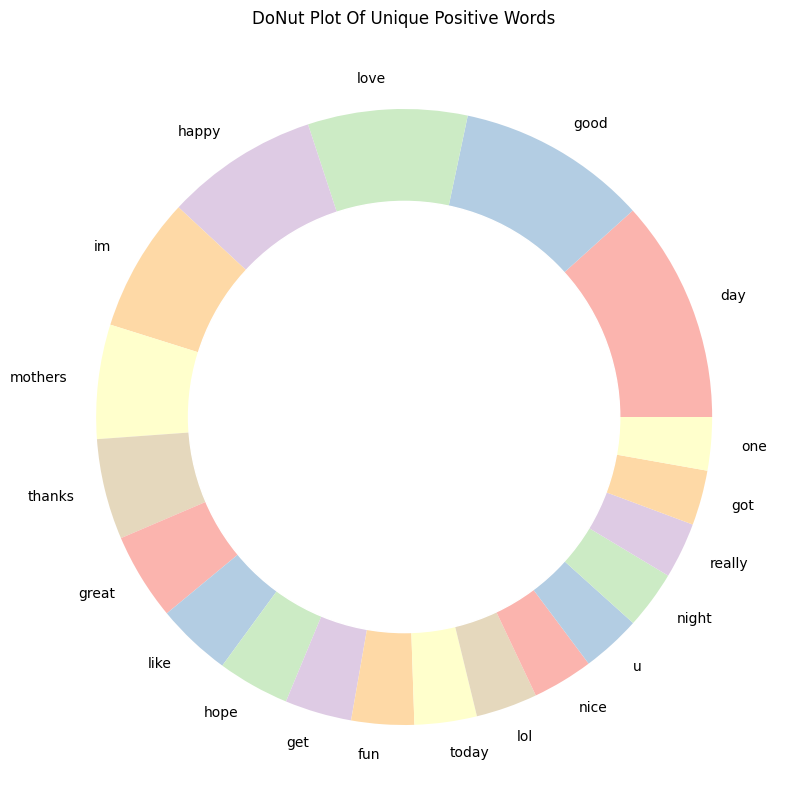

In [89]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['Count'], labels=Unique_Positive.Word, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [90]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


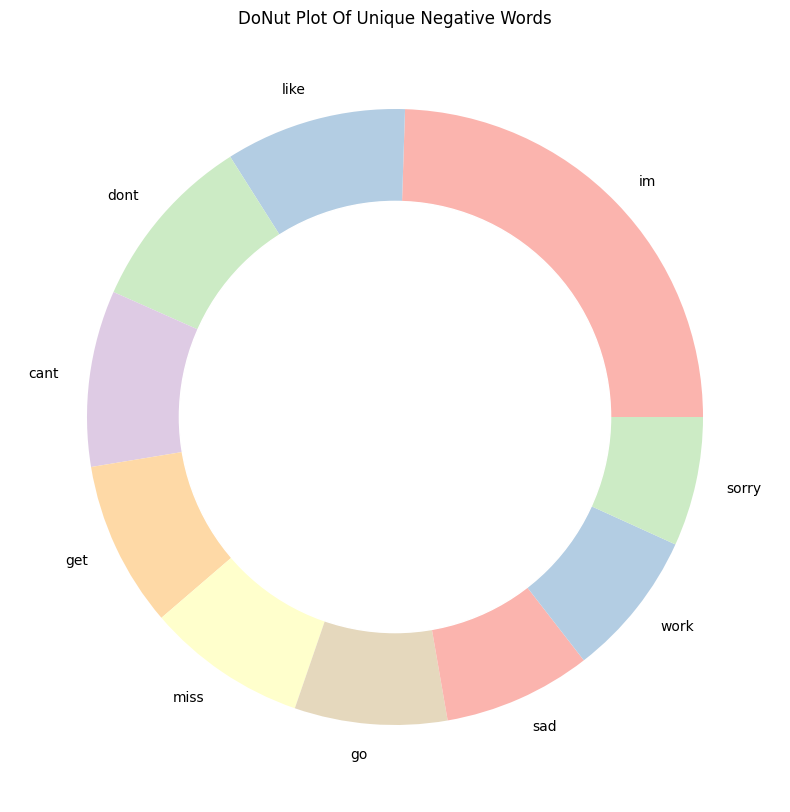

In [91]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['Count'], labels=Unique_Negative.Word, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [92]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


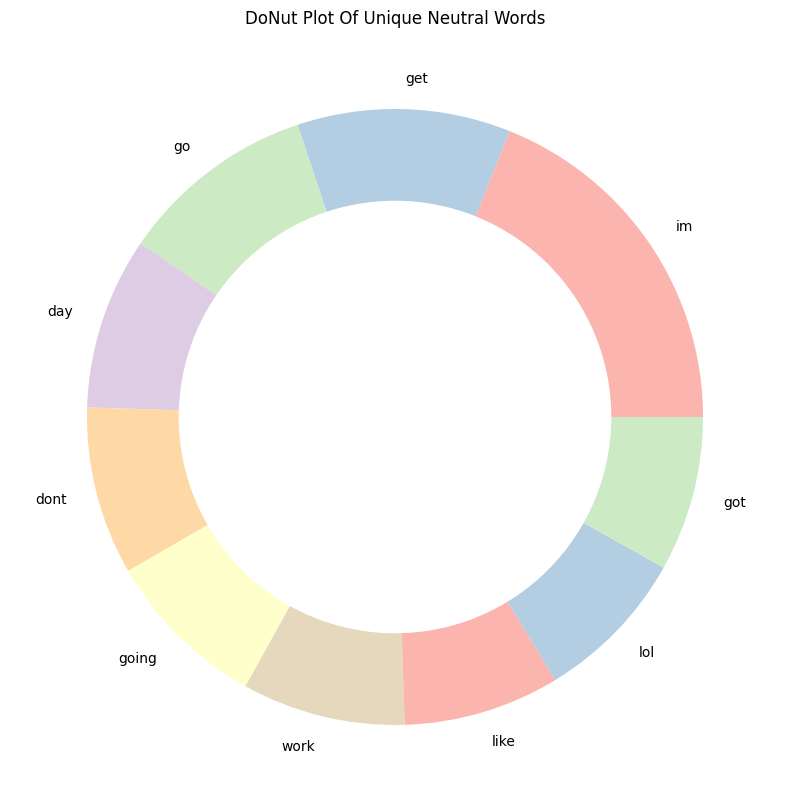

In [93]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['Count'], labels=Unique_Neutral.Word, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

In [94]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
d = '/kaggle/input/masks-for-wordclouds/'

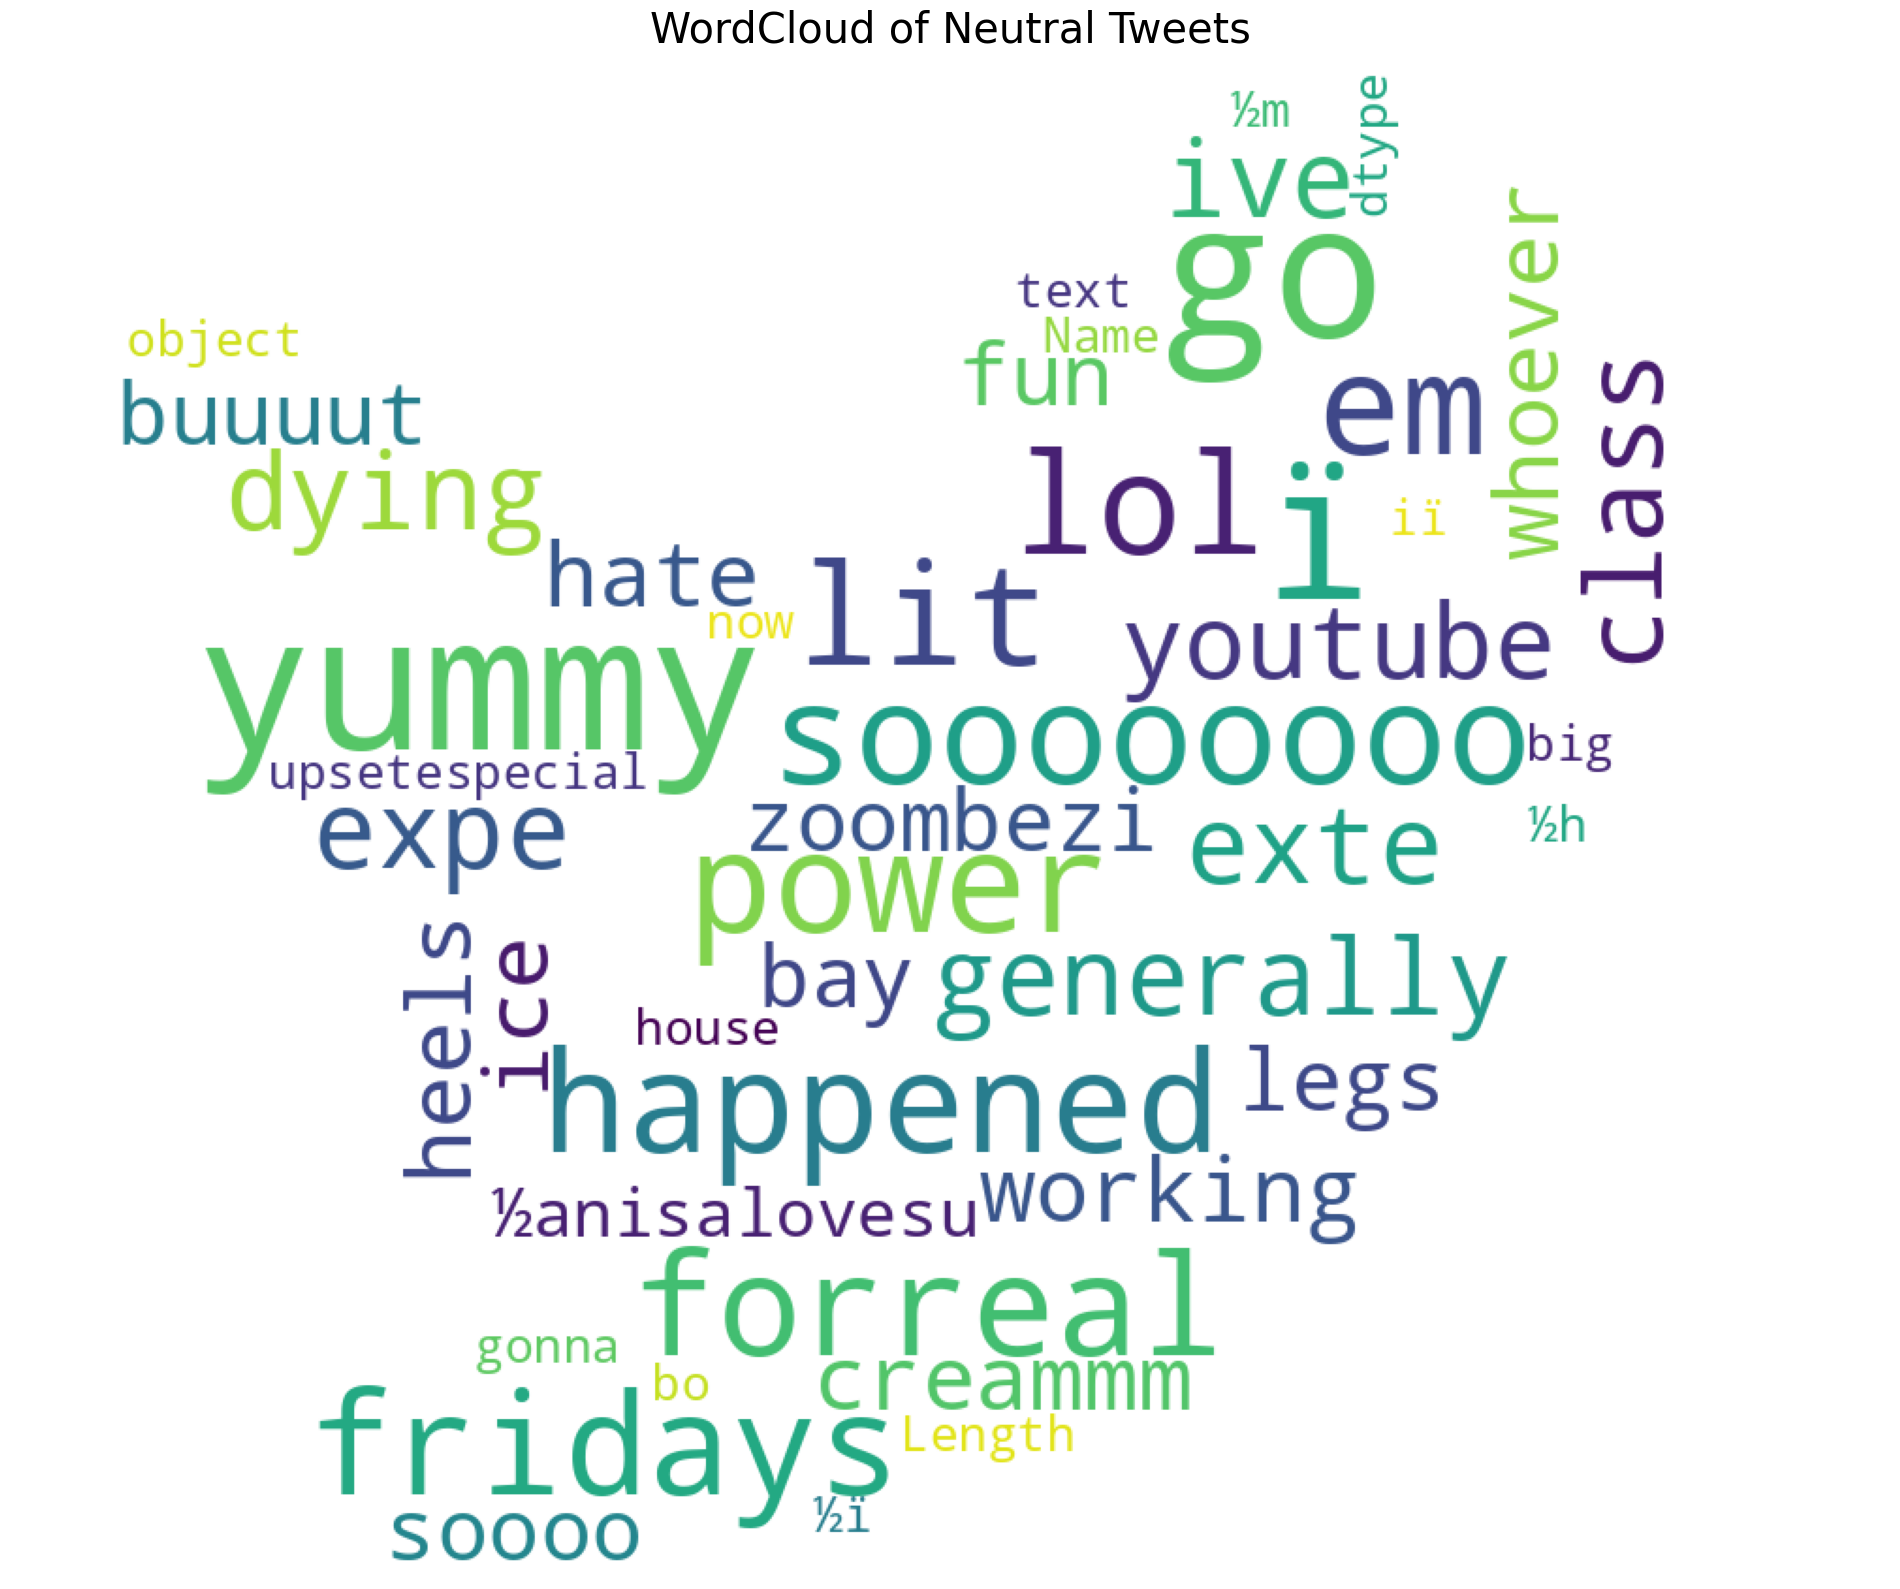

In [96]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

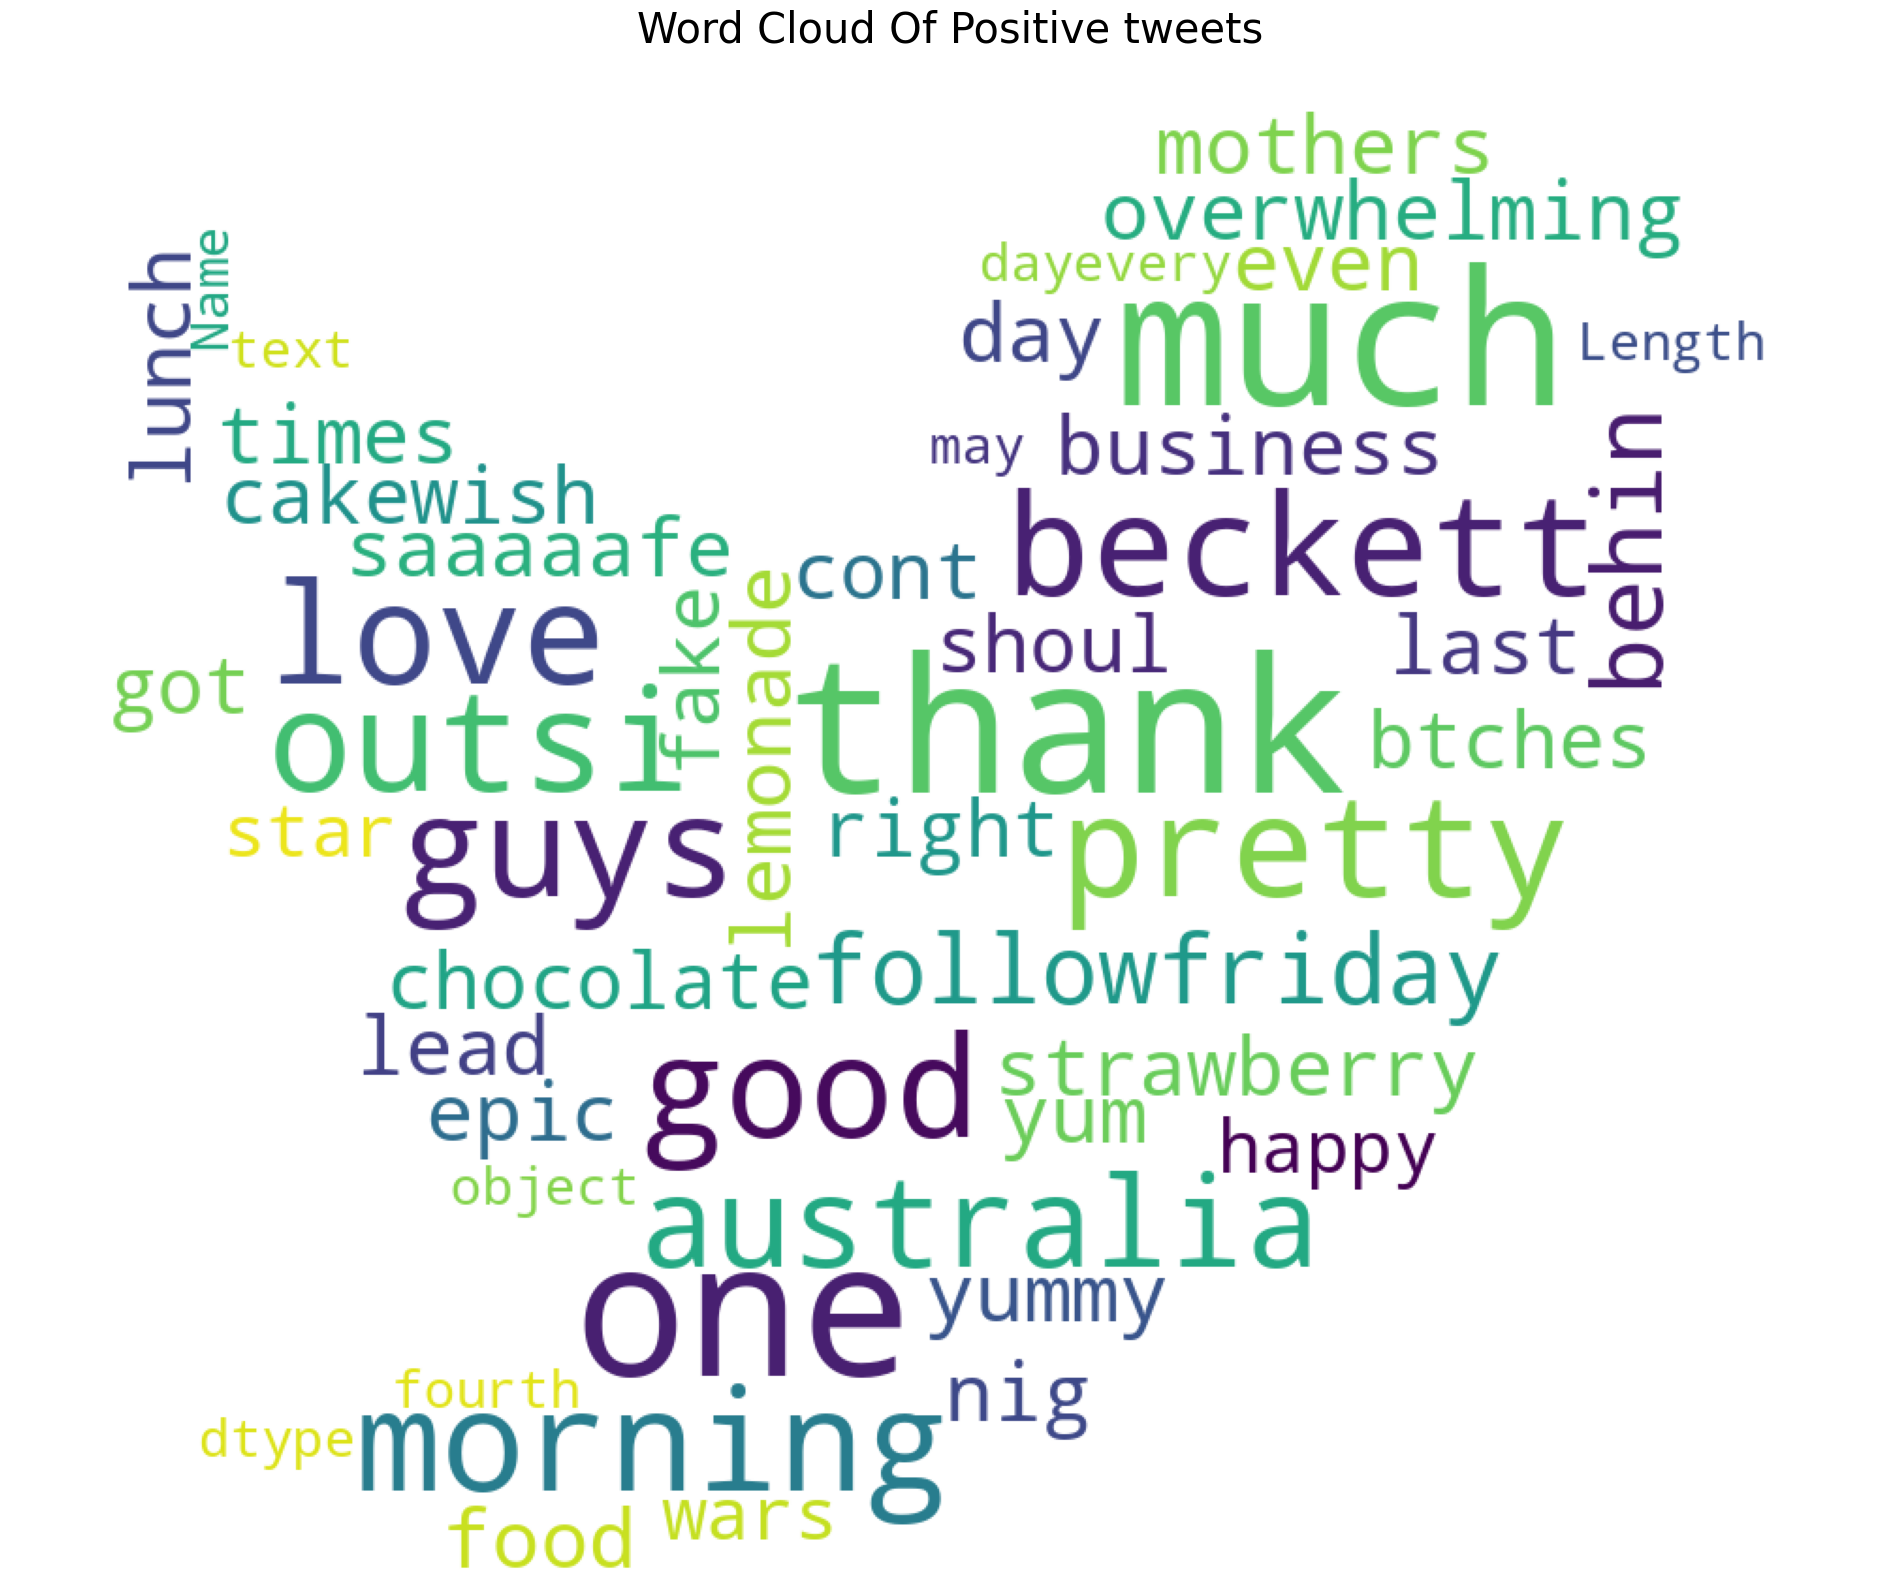

In [97]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

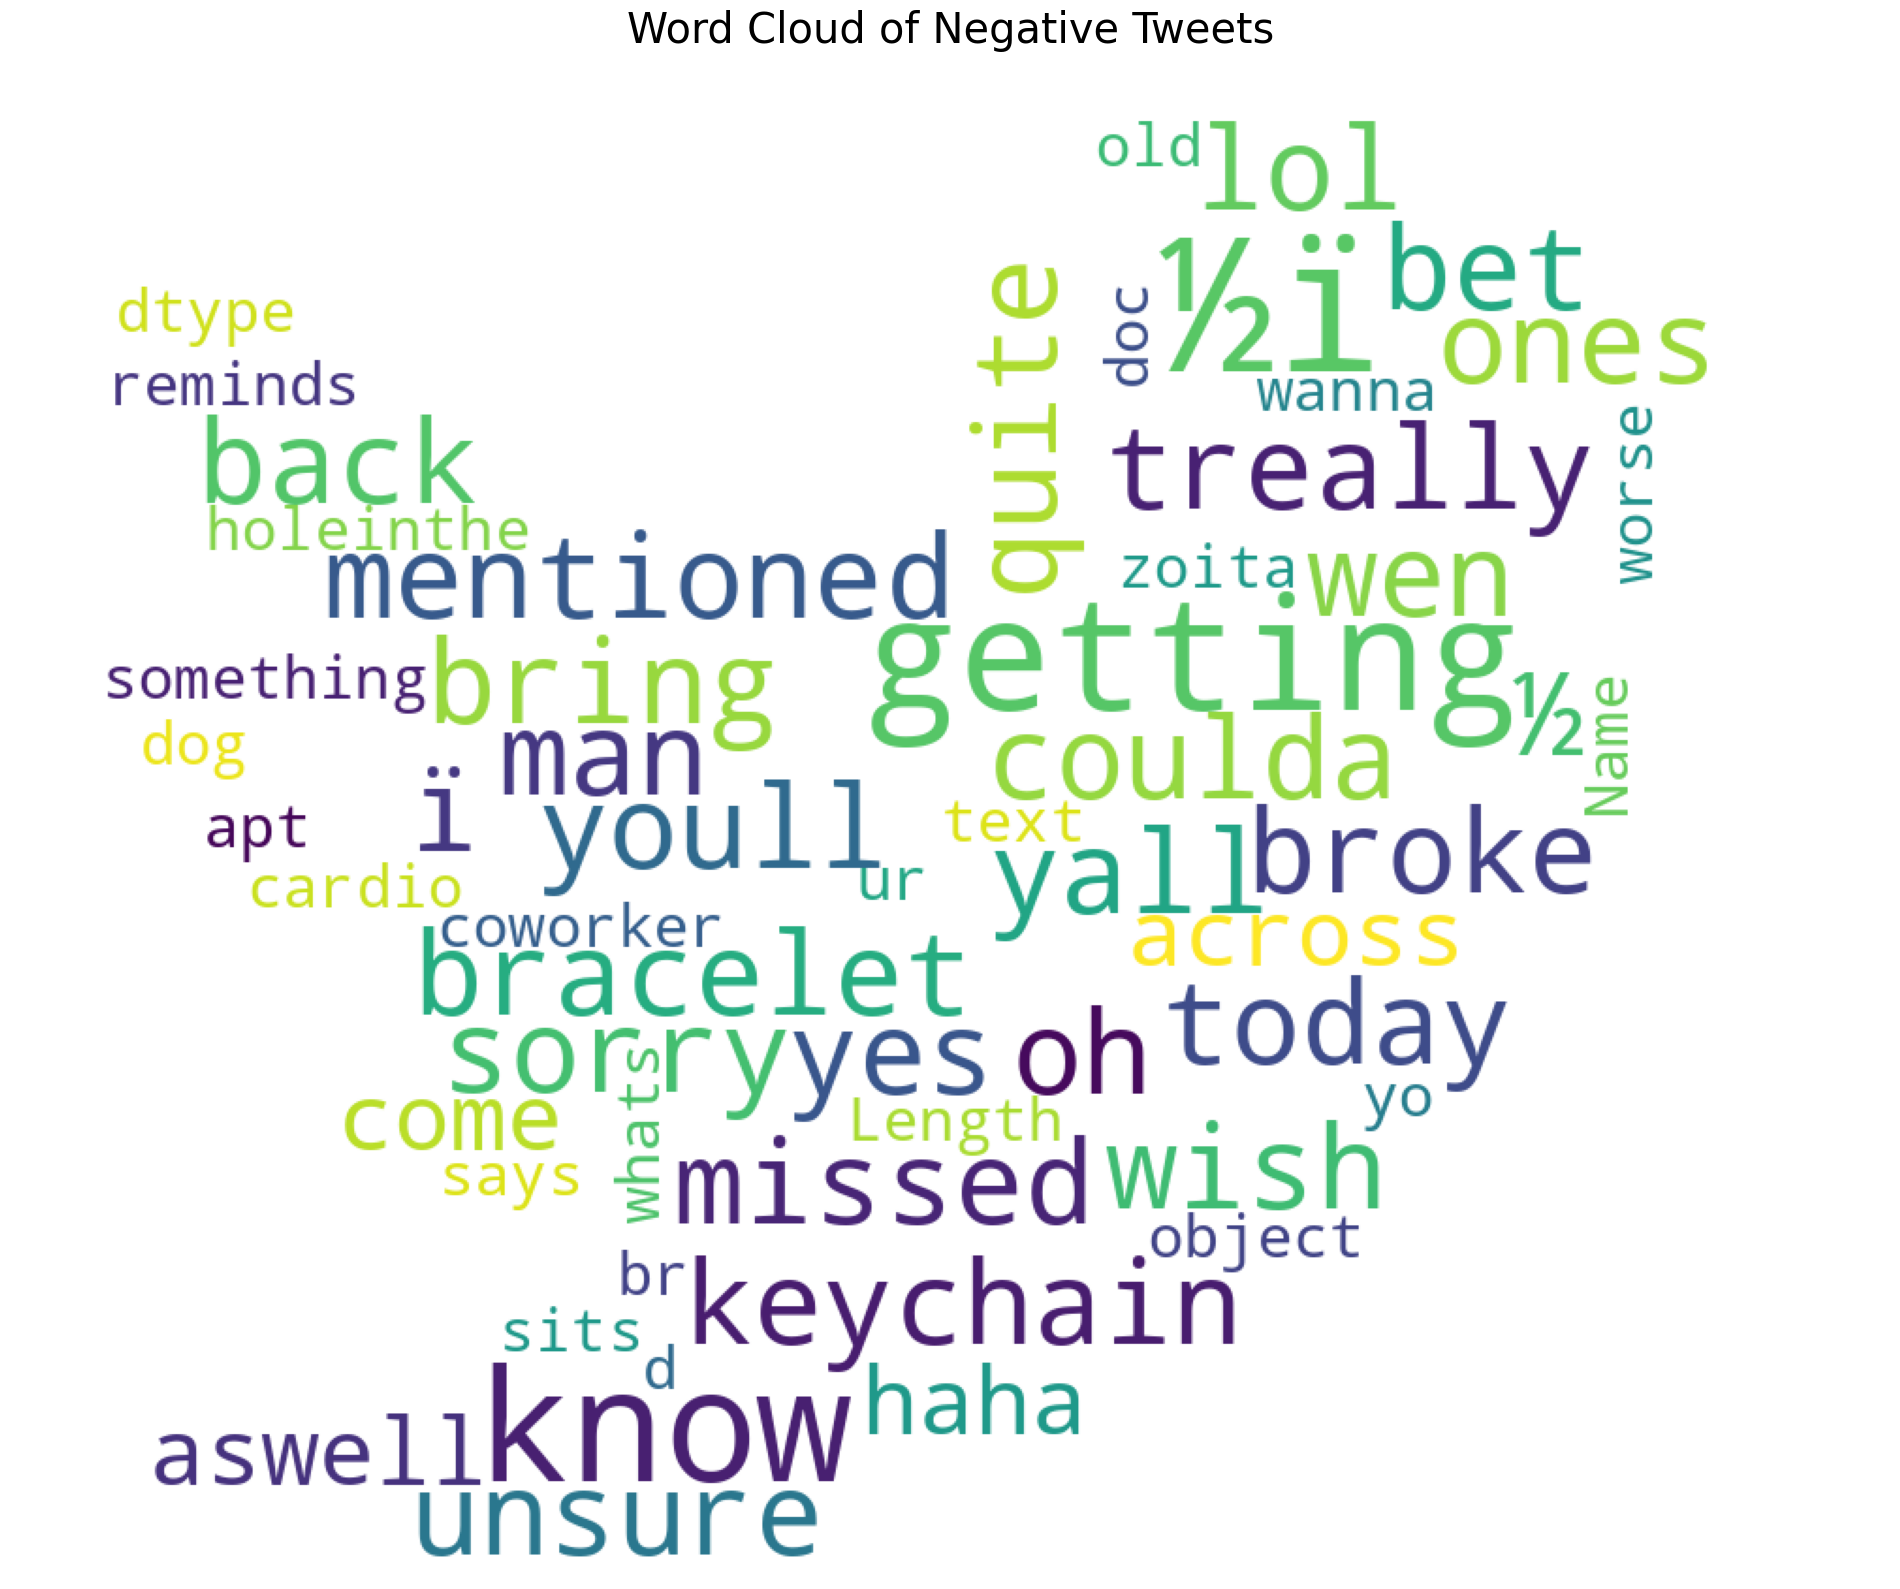

In [98]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

In [100]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [101]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [102]:
df_train = df_train[df_train['Num_words_text']>=3]

In [103]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to
    given output directory'''

    output_dir = f'../working/{output_dir}'
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [132]:
import spacy
from spacy.training import Example

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline, and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # Create or get the NER pipeline component
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")

    # Add labels to the NER component
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Disable other components during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            optimizer = nlp.begin_training()
        else:
            optimizer = nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            losses = {}

            # Create batches of training data
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                examples = []
                for text, annotations in batch:
                    examples.append(Example.from_dict(nlp.make_doc(text), annotations))

                # Update the model with Example objects
                nlp.update(
                    examples,  # Batch of Example objects
                    drop=0.5,  # Dropout rate
                    losses=losses,
                    sgd=optimizer,
                )
            print(f"Iteration {itn}, Losses: {losses}")

    save_model(output_dir, nlp, 'st_ner')


In [133]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [134]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [135]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:55<01:50, 55.30s/it]

Iteration 0, Losses: {'ner': 12958.065209895936}


 67%|██████▋   | 2/3 [01:51<00:55, 55.75s/it]

Iteration 1, Losses: {'ner': 11737.38695261711}


100%|██████████| 3/3 [02:49<00:00, 56.35s/it]

Iteration 2, Losses: {'ner': 11389.683215271993}
Saved model to ../working/models/model_pos


In [136]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:52<01:45, 52.90s/it]

Iteration 0, Losses: {'ner': 12491.120422328062}


 67%|██████▋   | 2/3 [01:46<00:53, 53.17s/it]

Iteration 1, Losses: {'ner': 11336.211457198613}


100%|██████████| 3/3 [02:38<00:00, 52.96s/it]

Iteration 2, Losses: {'ner': 11117.844778749159}
Saved model to ../working/models/model_neg


In [137]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [142]:
selected_texts = []
MODELS_BASE_PATH = '../working/models/' # updated path

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')

    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))

df_test['selected_text'] = selected_texts

Loading Models  from  ../working/models/


In [143]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))


textID                                      selected_text
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh
1  96d74cb729                                               Good
2  eee518ae67  Recession hit Veronique Branquinho, she has to...
3  01082688c6                                        happy bday!
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!
5  726e501993                                      that`s great!
6  261932614e            I THINK EVERYONE HATES ME ON HERE   lol
7  afa11da83f   soooooo wish i could, but im in school and my...
8  e64208b4ef   and within a short time of the last clue all ...
9  37bcad24ca   What did you get?  My day is alright.. haven`...